In [3]:
from IP import reconstructFloorplan

corner_mask (17, 128, 128)
corner_seg (128, 128, 3)
door_mask (1, 128, 128)
door_seg (128, 128, 3)
entrance_mask (1, 128, 128)
entrance_seg (128, 128, 3)
room_mask (10, 128, 128)
room_seg (128, 128, 3)
shape_mask (1, 128, 128)
shape_seg (128, 128, 3)
wall_mask (1, 128, 128)
wall_seg (128, 128, 3)
window_mask (1, 128, 128)
window_seg (128, 128, 3)
0


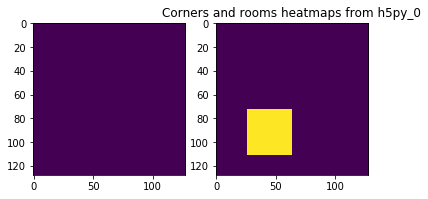

1


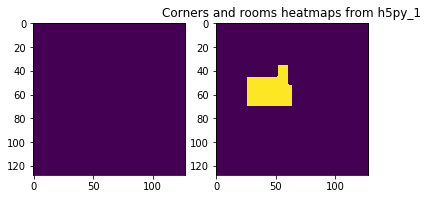

2


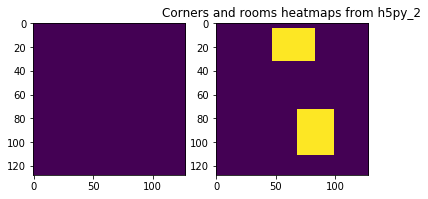

3


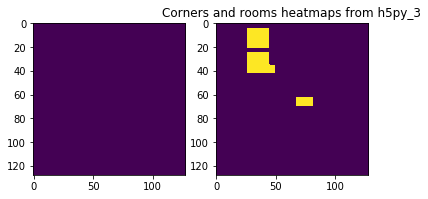

4


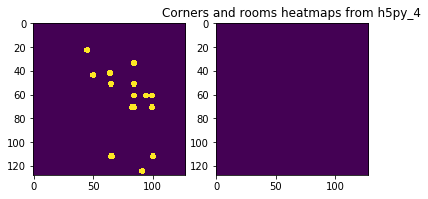

5


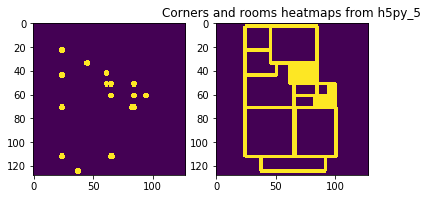

6


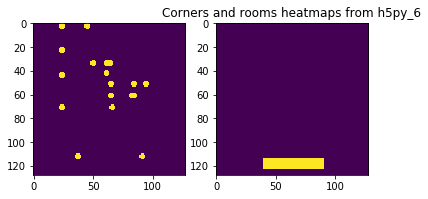

7


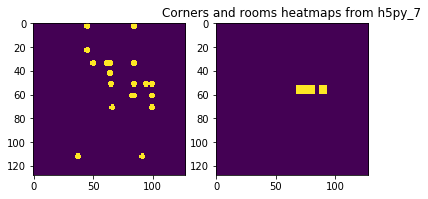

8


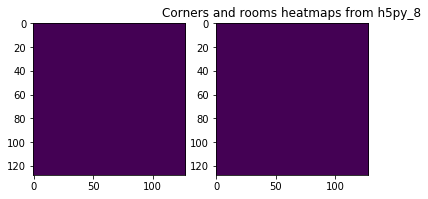

9


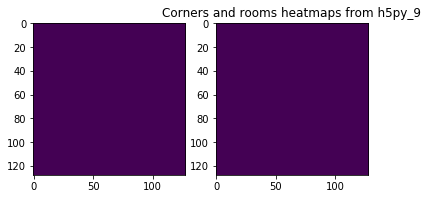

10


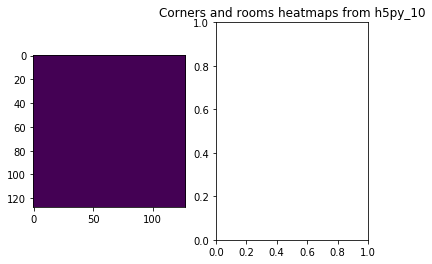

11


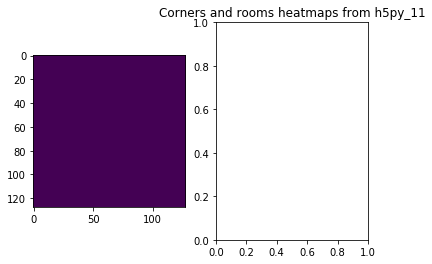

12


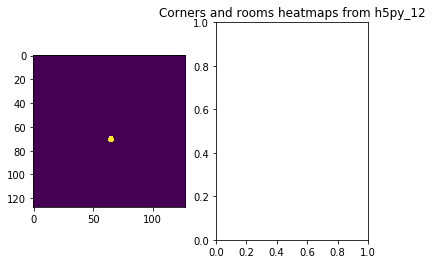

13


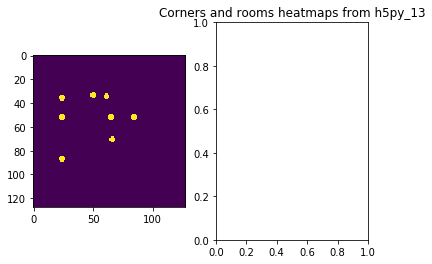

14


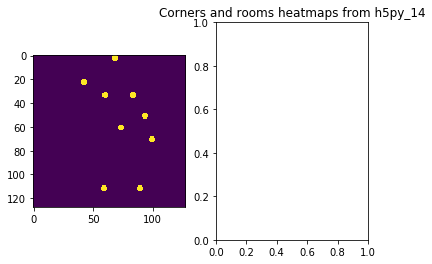

15


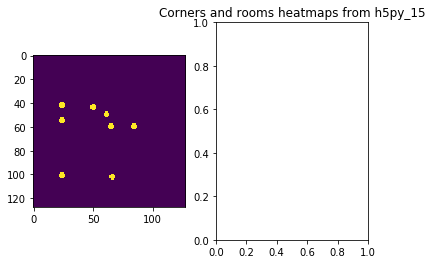

16


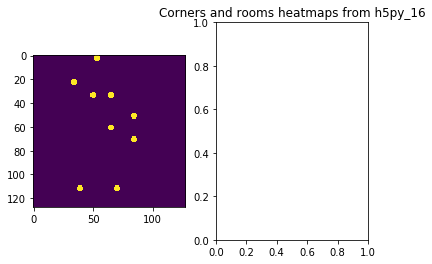

In [14]:
## This should be replaced by the output of the GAN 
## with the shapes below as ///// heatmaps //////
### wall Corners --> 256x256x13
### door Corners --> 256x256x4
### room Types   --> 256x256x10
import os
import numpy as np
import string
import cv2
from datetime import datetime
import matplotlib.pyplot as plt
import h5py
#filename = "input/0001.h5py"
filename = "input/0003.h5py"
with h5py.File(filename, "r") as f:
    loaded = dict((key,np.array(f.get(key))) for key in f.keys())
    for key in f.keys():
        print(key, loaded[key].shape)
        
for i in range(17):
    print(i)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(loaded['corner_mask'][i,:,:]) #without modification
    plt.subplot(1,2,2)
    plt.title('Corners and rooms heatmaps from h5py_{}'.format(i))
    if i <10 :
        plt.imshow(loaded['room_mask'][i,:,:]) #without modification
    plt.show()
    


0


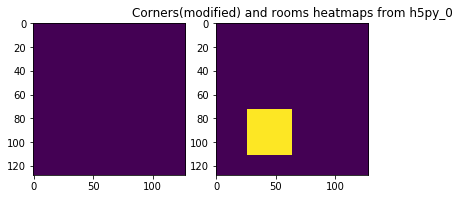

1


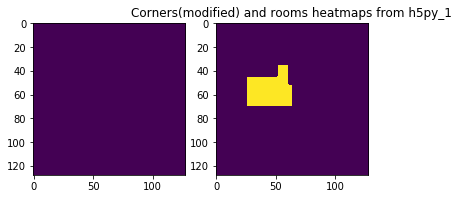

2


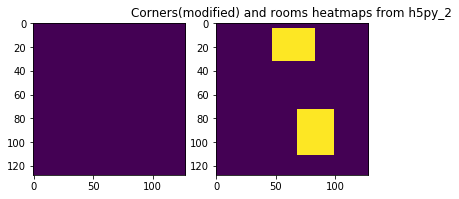

3


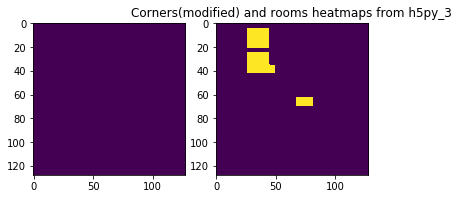

4


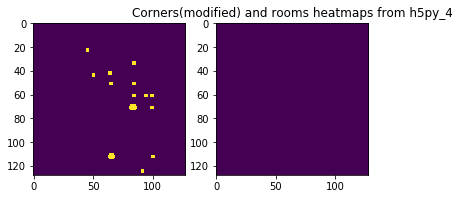

5


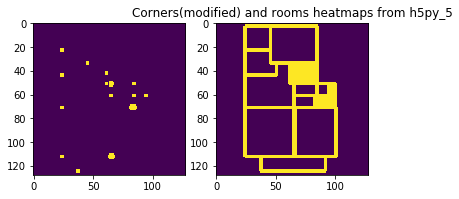

6


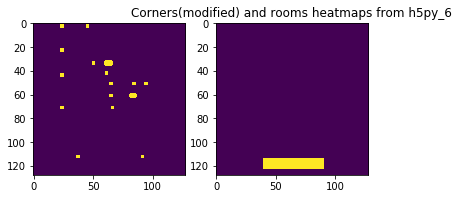

7


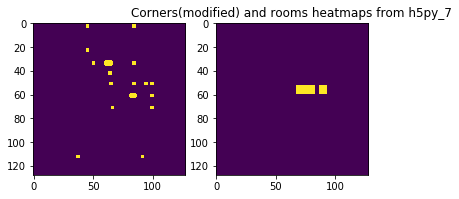

8


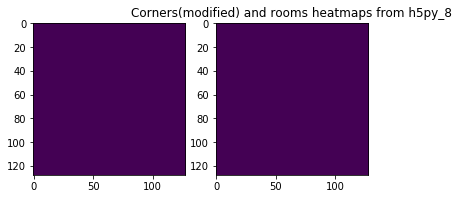

9


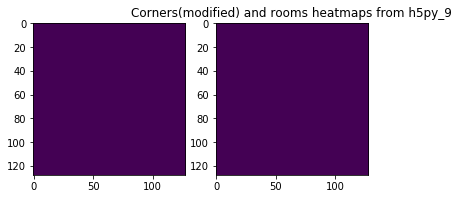

10


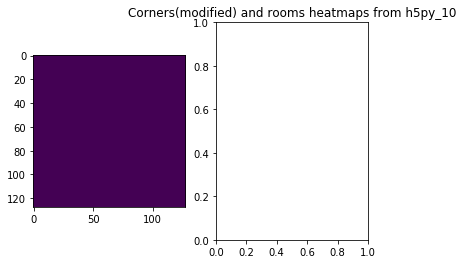

11


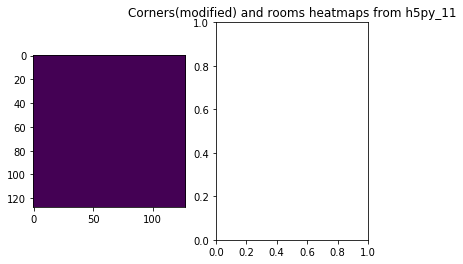

12


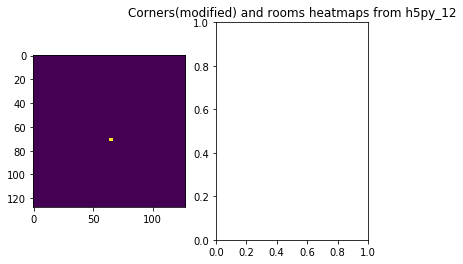

13


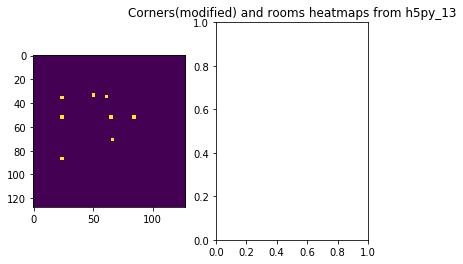

14


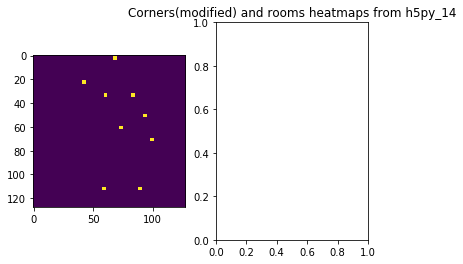

15


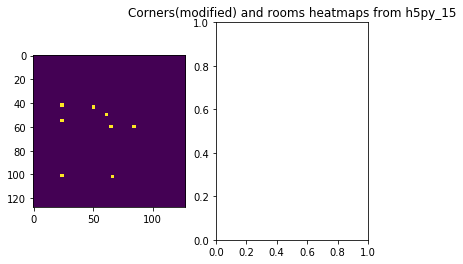

16


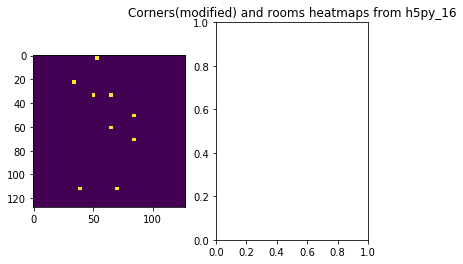

In [12]:
#With some modif of corners 

room_bis = np.copy(loaded['room_mask'])
room_bis[5,:,:] -= loaded['wall_mask'][0,:,:]
room_bis[1,:,:] += loaded['room_mask'][0,:,:]
room_bis[0,:,:]  = 1-loaded['shape_mask'][0,:,:]

nonzeros = np.array(np.nonzero(loaded['corner_mask']))
for idx in range(len(np.nonzero(loaded['corner_mask'])[0])):
    c,x,y = nonzeros[:,idx]
    carre = loaded['corner_mask'][c,(x-2):(x+3),(y-2):(y+3)]
    if carre.sum()==21:
        loaded['corner_mask'][c,(x-2):(x+3),(y-2):(y+3)] = np.zeros((5,5))
        loaded['corner_mask'][c,(x-1):(x+2),(y-1):(y+2)] = np.ones((3,3))

for i in range(17):
    print(i)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(loaded['corner_mask'][i,:,:]) #after modification
    plt.subplot(1,2,2)
    plt.title('Corners(modified) and rooms heatmaps from h5py_{}'.format(i))
    if i <10 :
        plt.imshow(loaded['room_mask'][i,:,:]) #without modification
    plt.show()
    


In [5]:
alphabet = string.ascii_lowercase.replace('t', '').replace('n', '')

threshold_text = 2
def contains_letter(string):
    for letter in alphabet:
        if letter in string:
            return True
    return False

def dist(x1, x2):
    sommes = [abs(x1[i] - x2[i]) for i in range(len(x1))]
    return sommes


def getter_line(line):
    x, j = [], 0
    counter_points = 0
    for i in range(len(line)):
        if line[i] == " ":
            if counter_points == 4:
                break
            x.append(float(line[j:i + 1]))
            j = i + 1
            counter_points += 1
    return x


In [14]:
def full_ip(cornerHeatmaps,roomHeatmaps,folder_outputs):
    gaps = [1, 3, 3, 5, 7]  # [1, 3, 3, 3]  # [1, 3, 3]
    distances = [3, 3, 5, 5, 7]  # [3, 1, 9, 7]  # [3, 1, 9]
    lengths = [1, 3, 3, 5, 7]  # [1, 3, 3, 7]  # [1, 3, 3]
    # [0.02, 0.02, 0.02, 0.02]  # [0.02, 0.02, 0.02]
    heatmaps_wall = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
    
    for gap, distanceThreshold, lengthThreshold, heatmapValueThresholdWall in zip(gaps, distances, lengths, heatmaps_wall):
        output_prefix = folder_outputs + \
                '_gap_{}_dist_{}_length_{}_wall_{}'.format(
                gap, distanceThreshold, lengthThreshold,
                heatmapValueThresholdWall)
        print(output_prefix)
        reconstructFloorplan(
        cornerHeatmaps[:, :, :13],
        cornerHeatmaps[:, :, 13:17],
        roomHeatmaps,
        output_prefix=output_prefix,
        densityImage=None,
        gt_dict=None,
        gt=False,
        gap=gap,
        distanceThreshold=distanceThreshold,
        lengthThreshold=lengthThreshold,
        debug_prefix='test',
        save_image=True,
        heatmapValueThresholdWall=heatmapValueThresholdWall,
        heatmapValueThresholdDoor=heatmapValueThresholdWall,  # same threshold here
        heatmapValueThresholdIcon=heatmapValueThresholdWall,  # same threshold here
        enableAugmentation=True)
   
    files = os.listdir(folder_outputs)
    all_txt = [folder_outputs + file for file in files if file.endswith("floorplan.txt")]
    all_lines = [line.replace("\t8", " ").replace("\t6", " ").replace("\t3", " ").replace("\t", " ") for txt in all_txt
                 for line in open(txt, "r") if len(line) > 10]
    all_lines = [line for line in all_lines]

    txt_main_int = [
        line for line in all_lines if not contains_letter(line)]
    txt_main_str = [line for line in all_lines if contains_letter(line)]

    def filtering(text):
        global gaping
        gaping = 0
        i = 0
        while i < len(text) - gaping:
            j = 0
            while j < len(text) - gaping:
                if j != i:
                    distances = dist(getter_line(text[i]), getter_line(
                        text[j]))
                    conditions = [dist < threshold_text for dist in distances]
                    if all(conditions):
                        txt_main_int.pop(j)
                        gaping += 1
                        j -= 1
                j += 1
            i += 1

    # sum of masks
    images = np.zeros((128, 128, 3))
    for file in files:
        if file.endswith('image.png'):
            images += cv2.imread(os.path.join(folder_outputs, file), 1)
    cv2.imwrite(folder_outputs + '_sum' + '.png', images)

    # sum of txts
    filtering(txt_main_int)
    filtering(txt_main_str)
    txt_info = ['128 128 \n', str(len(txt_main_int)) + '\n']
    with open(folder_outputs + "_sum.txt", "w") as writer_main:
        writer_main.writelines(txt_info)
        writer_main.writelines(txt_main_int)
        writer_main.writelines(txt_main_str)


In [15]:
folder_outputs = 'output/{}/'.format(
        datetime.now().strftime('%m-%d_%H-%M-%S'))
os.makedirs(folder_outputs)

#replace with output heatmaps
full_ip(loaded['corner_mask'].T,room_bis.T,folder_outputs)

output/04-25_17-55-31/_gap_1_dist_3_length_1_wall_1e-25
output/04-25_17-55-31/_gap_3_dist_3_length_3_wall_1e-08
output/04-25_17-55-31/_gap_3_dist_5_length_3_wall_1e-08
output/04-25_17-55-31/_gap_5_dist_5_length_5_wall_1e-08
output/04-25_17-55-31/_gap_7_dist_7_length_7_wall_1e-09
